# House Sales in King County, USA

A dataset from [House Sales in King County, USA](https://www.kaggle.com/harlfoxem/housesalesprediction) containing prices of houses is provided.

We want to build a  model that can determine the prices of a given house according to a number of features. We will use a subset of the data for training and the remaining for testing our modeling.

## Outline

We separate the project in 3 steps:

**Data Loading and Exploratory Data Analysis:** Load the data and analyze it to obtain an accurate picture of it, its features, its values (and whether they are incomplete or wrong), its data types among others. Also, the creation of different types of plots in order to help us understand the data and make the model creation easier.

**Feature Engineering / Modeling:** Once we have the data, we create some features and then the modeling stage begins, making use of different models with different transformers, we will hopefully produce a model that fits our expectations of performance. Once we have that model, a process of tuning it to the training data would be performed.

**Results and Conclusions:** Finally, with our tuned model, we  predict against the test set, then we review those results against their actual values to determine the performance of the model, and finally, outline our conclusions.

In [59]:
library(caret)
library(GGally)
library(leaflet)
library(ggplot2)
library(geosphere)
library(IRdisplay)
library(lubridate)
library(gridExtra)
library(doParallel)
library(data.table)
library(htmlwidgets)

### Setting up the cluster to run in parallel

This will optimize model training times

In [8]:
cluster <- makeCluster(detectCores() - 1, outfile="")
registerDoParallel(cluster)

### Setting Seed

We specify a seed value to ensure reproducibility

In [9]:
set.seed(1000)

### Data Loading

Here we load the necessary data from Github Gists, describe its contents and print its first rows.

In [10]:
train<-fread('https://gist.githubusercontent.com/akoury/da3cdb6bfde9eb2f3f5d3f5246dfd6b6/raw/1b057c119af85ab22330a50239d5c0bdbab7fb64/train.csv')
test<-fread('https://gist.githubusercontent.com/akoury/83c7ce5544dc467a696967bd13d4f498/raw/e9a54dce92f6d115d1e08cbf7668f5cf70e60598/test.csv')

Warning message in require_bit64():
“Some columns are type 'integer64' but package bit64 is not installed. Those columns will print as strange looking floating point data. There is no need to reload the data. Simply install.packages('bit64') to obtain the integer64 print method and print the data again.”Warning message in require_bit64():
“Some columns are type 'integer64' but package bit64 is not installed. Those columns will print as strange looking floating point data. There is no need to reload the data. Simply install.packages('bit64') to obtain the integer64 print method and print the data again.”

In [11]:
str(train)

Classes ‘data.table’ and 'data.frame':	17277 obs. of  21 variables:
 $ id           : 'integer64' num  4.54e-314 2.29e-315 1.10e-314 3.05e-314 3.16e-314 ...
 $ date         : chr  "5/13/2014" "8/27/2014" "7/18/2014" "1/30/2015" ...
 $ price        : num  225000 641250 810000 330000 530000 ...
 $ bedrooms     : int  3 3 4 4 4 4 4 3 4 3 ...
 $ bathrooms    : num  1.5 2.5 3.5 1.5 1.75 3.5 3.25 2.25 2.5 1.5 ...
 $ sqft_living  : int  1250 2220 3980 1890 1814 3120 4160 1440 2250 2540 ...
 $ sqft_lot     : int  7500 2550 209523 7540 5000 5086 47480 10500 6840 9520 ...
 $ floors       : num  1 3 2 1 1 2 2 1 2 1 ...
 $ waterfront   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ view         : int  0 2 2 0 0 0 0 0 0 0 ...
 $ condition    : int  3 3 3 4 4 3 3 3 3 3 ...
 $ grade        : int  7 10 9 7 7 9 10 8 9 8 ...
 $ sqft_above   : int  1250 2220 3980 1890 944 2480 4160 1130 2250 1500 ...
 $ sqft_basement: int  0 0 0 0 870 640 0 310 0 1040 ...
 $ yr_built     : int  1967 1990 2006 1967 1951 2008 1995 1983

In [12]:
summary(train)

       id        date               price            bedrooms     
 Min.   :0   Length:17277       Min.   :  78000   Min.   : 1.000  
 1st Qu.:0   Class :character   1st Qu.: 320000   1st Qu.: 3.000  
 Median :0   Mode  :character   Median : 450000   Median : 3.000  
 Mean   :0                      Mean   : 539865   Mean   : 3.369  
 3rd Qu.:0                      3rd Qu.: 645500   3rd Qu.: 4.000  
 Max.   :0                      Max.   :7700000   Max.   :33.000  
   bathrooms      sqft_living       sqft_lot           floors     
 Min.   :0.500   Min.   :  370   Min.   :    520   Min.   :1.000  
 1st Qu.:1.750   1st Qu.: 1430   1st Qu.:   5050   1st Qu.:1.000  
 Median :2.250   Median : 1910   Median :   7620   Median :1.500  
 Mean   :2.114   Mean   : 2080   Mean   :  15186   Mean   :1.493  
 3rd Qu.:2.500   3rd Qu.: 2550   3rd Qu.:  10695   3rd Qu.:2.000  
 Max.   :8.000   Max.   :13540   Max.   :1164794   Max.   :3.500  
   waterfront            view          condition         grade

In [13]:
head(train)

id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,⋯,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
4.537352e-314,5/13/2014,225000,3,1.50,1250,7500,1,0,0,⋯,7,1250,0,1967,0,98030,47.3719,-122.215,1260,7563
2.292468e-315,8/27/2014,641250,3,2.50,2220,2550,3,0,2,⋯,10,2220,0,1990,0,98117,47.6963,-122.393,2200,5610
1.098841e-314,7/18/2014,810000,4,3.50,3980,209523,2,0,2,⋯,9,3980,0,2006,0,98024,47.5574,-121.890,2220,65775
3.045372e-314,1/30/2015,330000,4,1.50,1890,7540,1,0,0,⋯,7,1890,0,1967,0,98155,47.7534,-122.318,1890,8515
3.158069e-314,5/23/2014,530000,4,1.75,1814,5000,1,0,0,⋯,7,944,870,1951,0,98115,47.6840,-122.281,1290,5000
3.939779e-314,5/20/2014,953007,4,3.50,3120,5086,2,0,0,⋯,9,2480,640,2008,0,98115,47.6762,-122.288,1880,5092


### Missing Data

We check if there is any missing data per column.

In [14]:
sapply(train, function(x) sum(is.na(x)))

id          date         price      bedrooms     bathrooms 
            0             0             0             0             0 
  sqft_living      sqft_lot        floors    waterfront          view 
            0             0             0             0             0 
    condition         grade    sqft_above sqft_basement      yr_built 
            0             0             0             0             0 
 yr_renovated       zipcode           lat          long sqft_living15 
            0             0             0             0             0 
   sqft_lot15 
            0

### Checking Duplicated Values

In [15]:
any(duplicated(train))

[1] FALSE

### Converting column types
Now we convert the data types of multiple columns.

#### Numericals

In [16]:
train[ , which(sapply(train, is.integer)):=lapply(.SD,as.numeric), .SDcols = sapply(train, is.integer)]
test[ , which(sapply(test, is.integer)):=lapply(.SD,as.numeric), .SDcols = sapply(test, is.integer)]

#### Dates
We extract the year, month and days since posting

In [17]:
train$date<-mdy(train$date)
train$year<-year(train$date)
train$month<-month(train$date)
train$days_since<-as.numeric(Sys.Date() - train$date)

test$date<-mdy(test$date)
test$year<-year(test$date)
test$month<-month(test$date)
test$days_since<-as.numeric(Sys.Date() - test$date)

### Dropping unneeded columnss
Now we drop unneeded columns.

In [18]:
train[, c('id','date'):=NULL]
test[, c('date'):=NULL]

## Exploratory Data Analysis

Here we will perform all of the necessary data analysis, with different plots that will help us understand the data and therefore, create a better model.

### Distribution of Apartment Prices

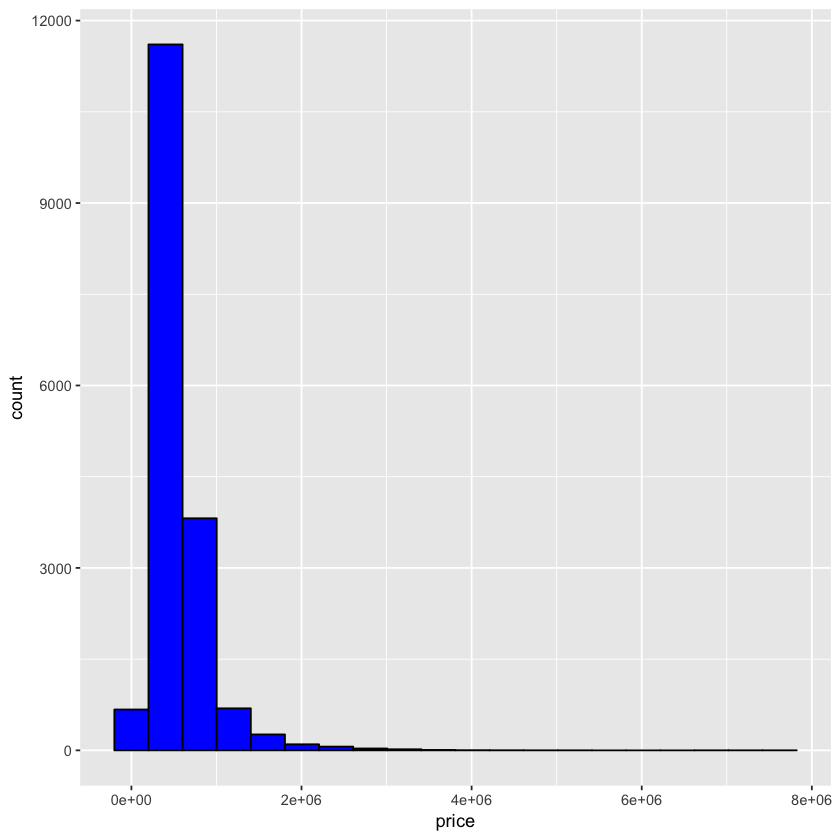

In [19]:
ggplot(train, aes(x=price))+ geom_histogram(bins=20, colour="black", fill="blue")

### Pair plots of each feature vs Price

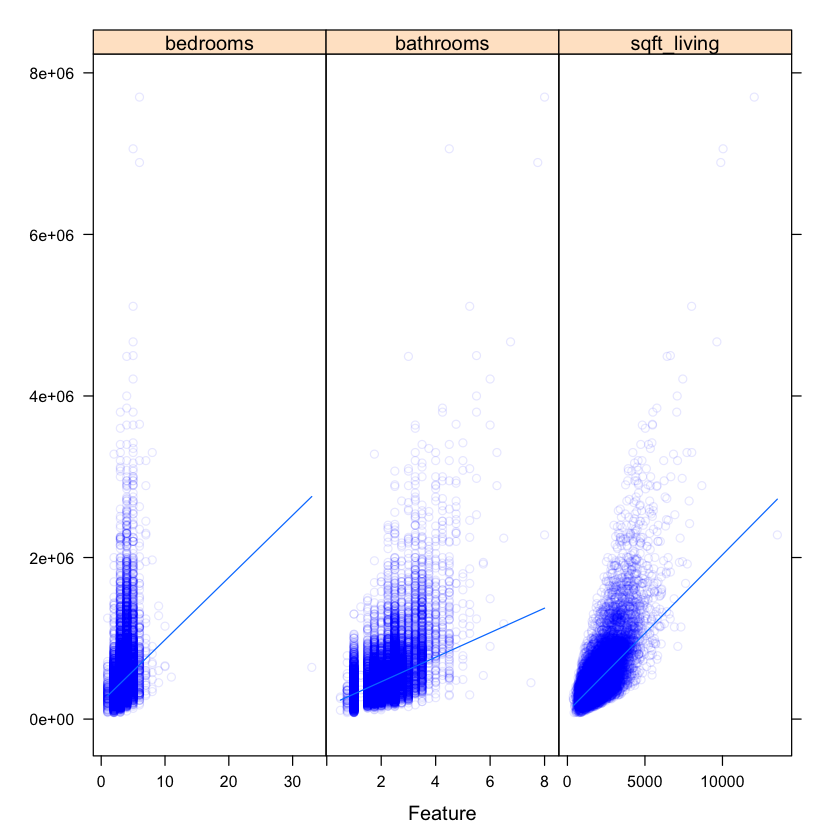

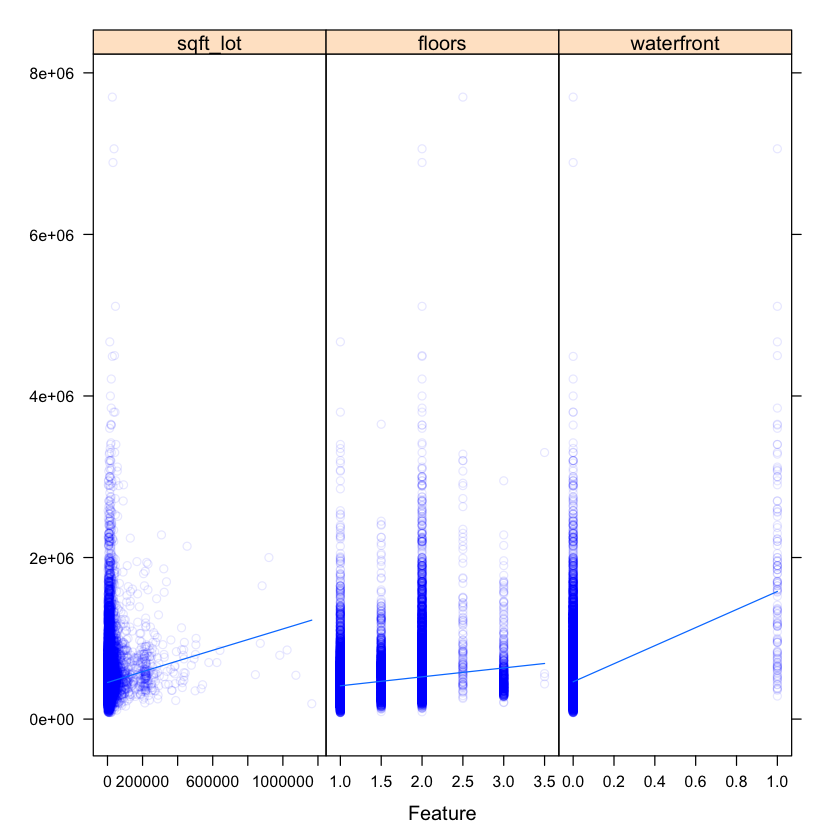

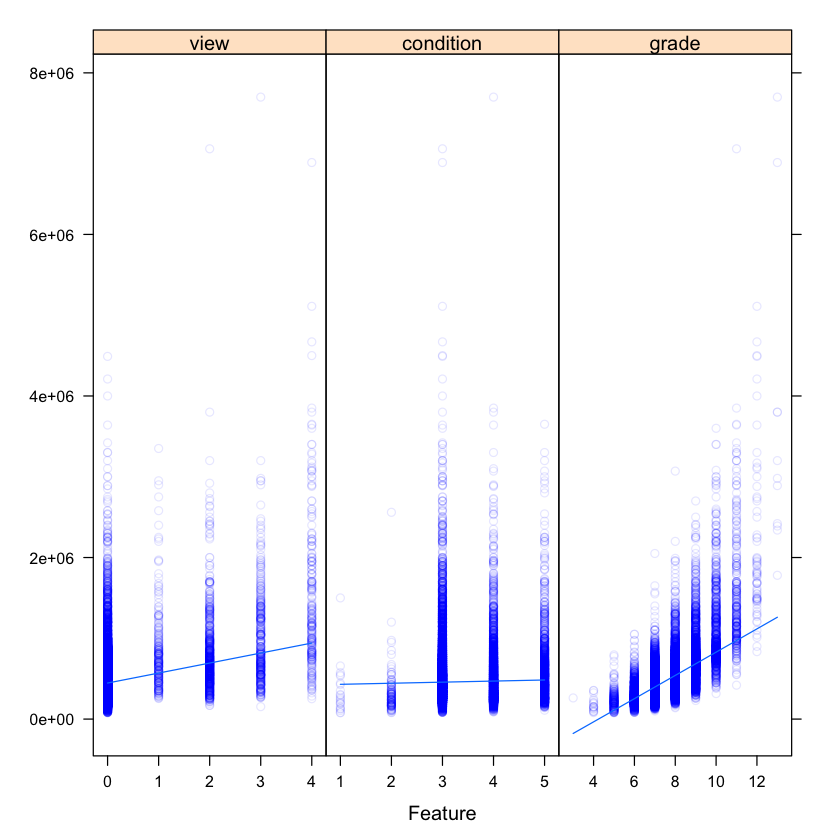

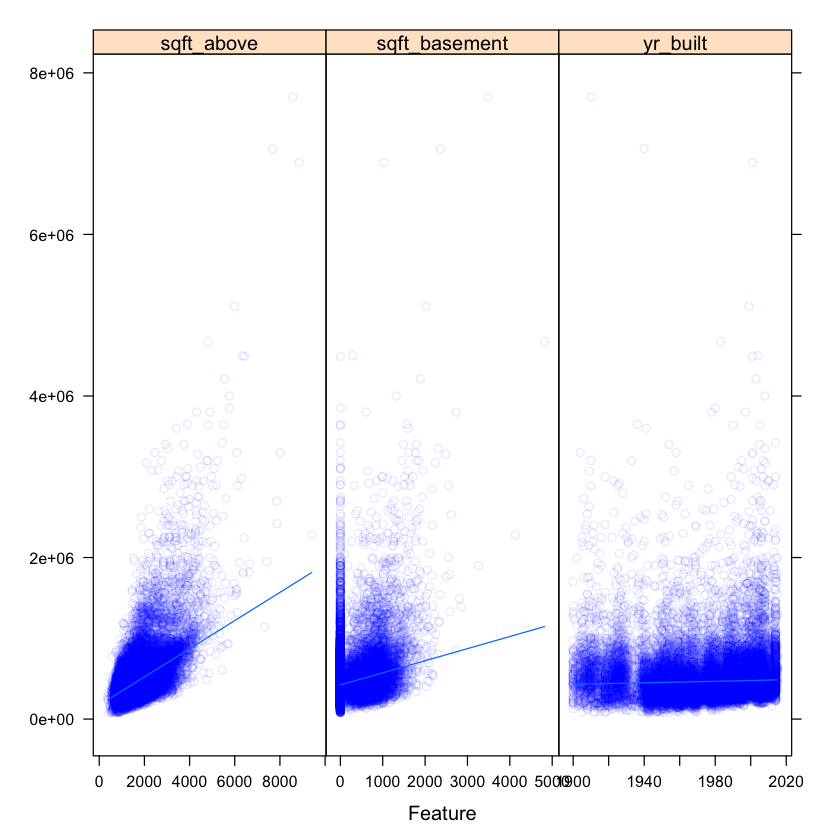

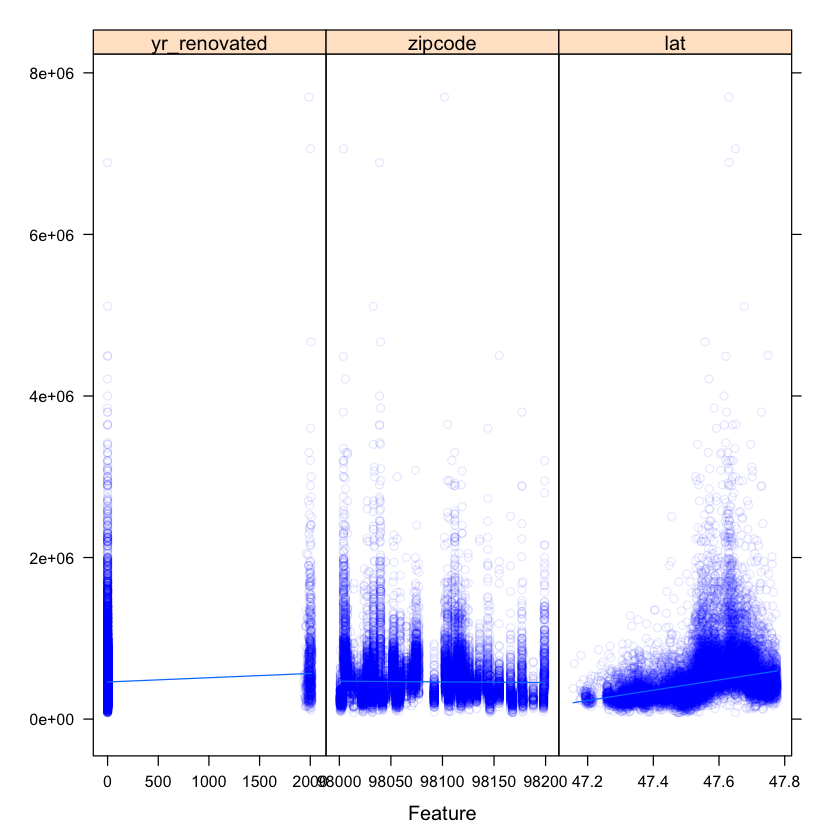

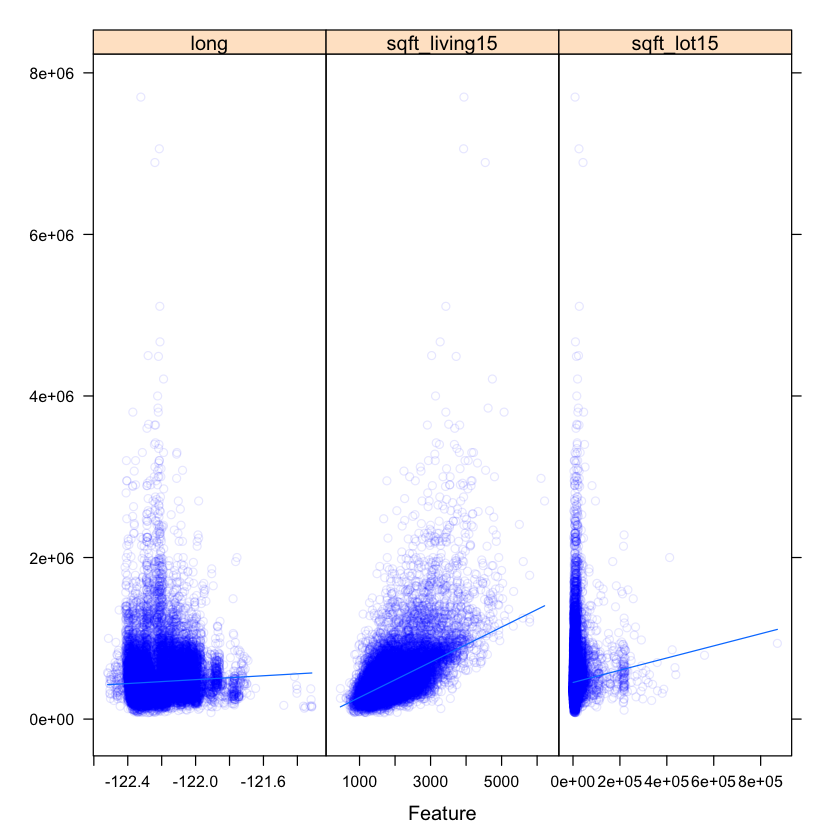

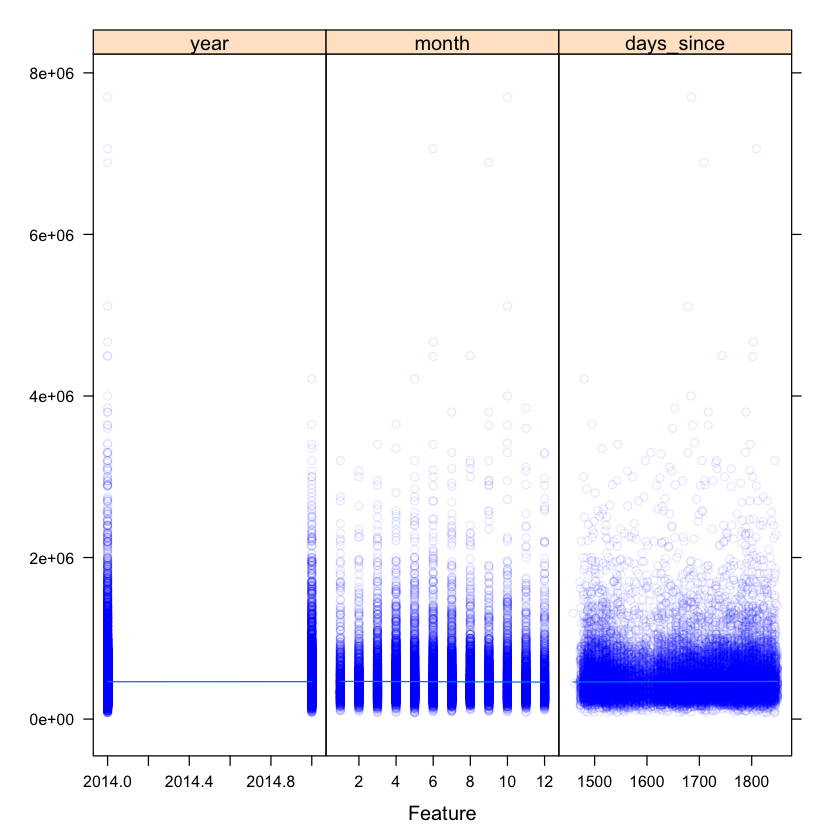

In [20]:
theme <- trellis.par.get()
theme$plot.symbol$col = "blue"
theme$plot.symbol$alpha = 0.1
trellis.par.set(theme)

featurePlot(x = train[, -"price"], y = train$price, plot = "scatter", type = c("p", "smooth"), span = 10, layout = c(3, 1))

### Feature values per level

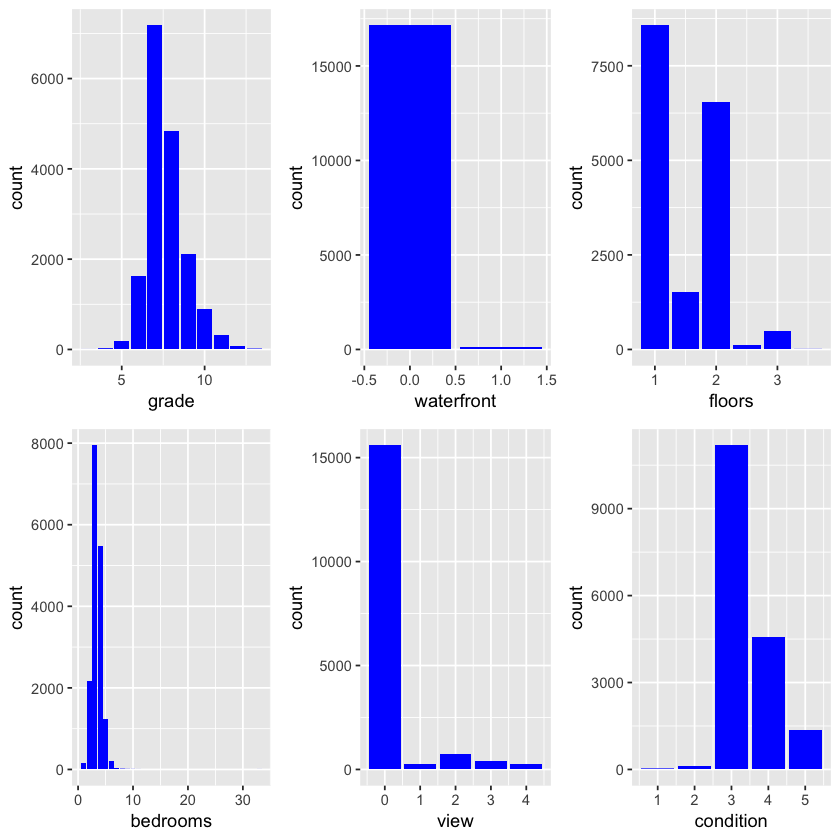

In [21]:
grade<-ggplot(train, aes(x=grade))+geom_bar(stat='count', fill = "blue")
waterfront<-ggplot(train, aes(x=waterfront))+geom_bar(stat='count', fill = "blue")
floors<-ggplot(train, aes(x=floors))+geom_bar(stat='count', fill = "blue")
bedrooms<-ggplot(train, aes(x=bedrooms))+geom_bar(stat='count', fill = "blue")
view<-ggplot(train, aes(x=view))+geom_bar(stat='count', fill = "blue")
condition<-ggplot(train, aes(x=condition))+geom_bar(stat='count', fill = "blue")
grid.arrange(grade, waterfront, floors, bedrooms, view, condition, ncol=3)

### Coefficient of Variation

The coefficient of variation is a dimensionless meassure of dispersion in data, the lower the value the less dispersion a feature has.

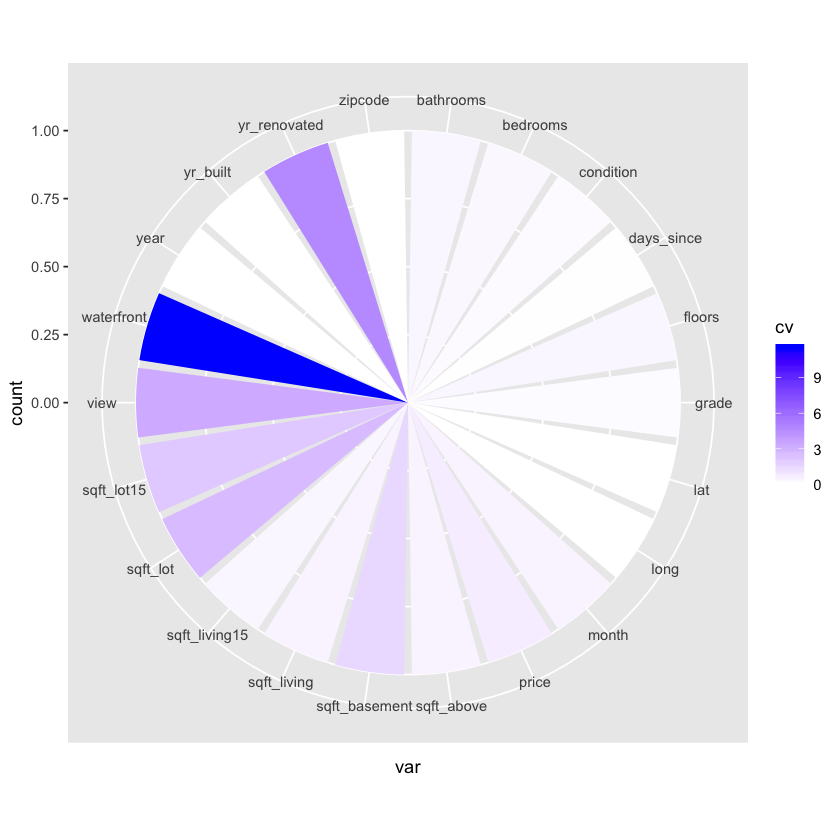

In [22]:
numeric_variables<-names(train)[sapply(train, is.numeric)]

sd_numeric_variables<-sapply(train[,numeric_variables, with=F], sd)
cv_numeric_variables<-sd_numeric_variables/colMeans(train[,numeric_variables, with=F])

ggplot(data.table(var=names(cv_numeric_variables),cv=cv_numeric_variables),
       aes(var,fill=cv))+geom_bar()+coord_polar()+scale_fill_gradient(low='white', high = 'blue')

Viewing variables with less than a 0.01 coefficient of variation

In [23]:
cv_numeric_variables[cv_numeric_variables < 0.01]

zipcode           lat          long          year 
 0.0005462536  0.0029200229 -0.0011541909  0.0002320742

### Boxplot of Numerical Variables

We review the distribution of numerical data through a boxplot for each variable that has a coefficient of variation higher than 0.4.

No id variables; using all as measure variables


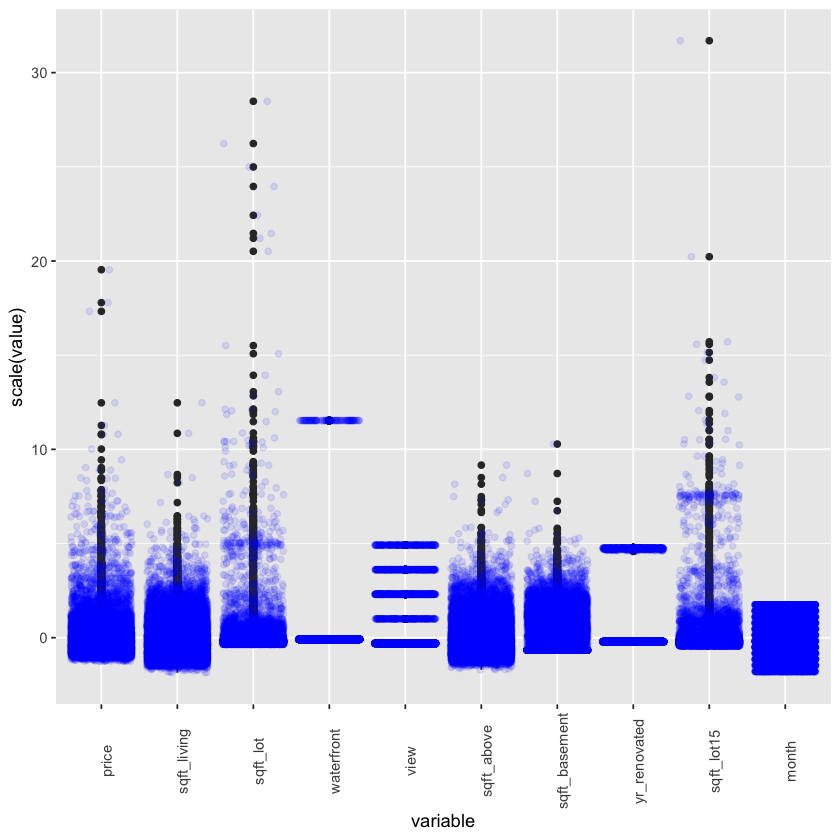

In [24]:
df<-train[, numeric_variables[cv_numeric_variables>0.4], with=F]
df<-data.frame(scale(df))
df<-melt(df)
       
ggplot(df, aes(x=variable, y=scale(value)))+geom_boxplot()+geom_jitter(alpha=.1, color="blue")+theme(axis.text.x = element_text(angle=90))

## Map of Apartments

In [25]:
centroid<-centroid(train[,c('long','lat')])
palette<-colorNumeric(palette = "plasma", domain = train$price)
map<-leaflet()
map<-addProviderTiles(map, "CartoDB.Positron")
map<-addCircles(map, lat =train$lat, lng =train$long, color=palette(train$price), fillOpacity = 1)
map<-addLegend(map, "bottomright", pal = palette, values = train$price, title = "House Prices", opacity = 1)
map<-setView(map, lng=centroid[1], lat=centroid[2], zoom = 11)
saveWidget(map, 'map.html')

In [26]:
display_html('<iframe src="map.html" width=1000, height=700></iframe>')

### Data Correlation

Now we analyze correlation in the data for both numerical and categorical columns

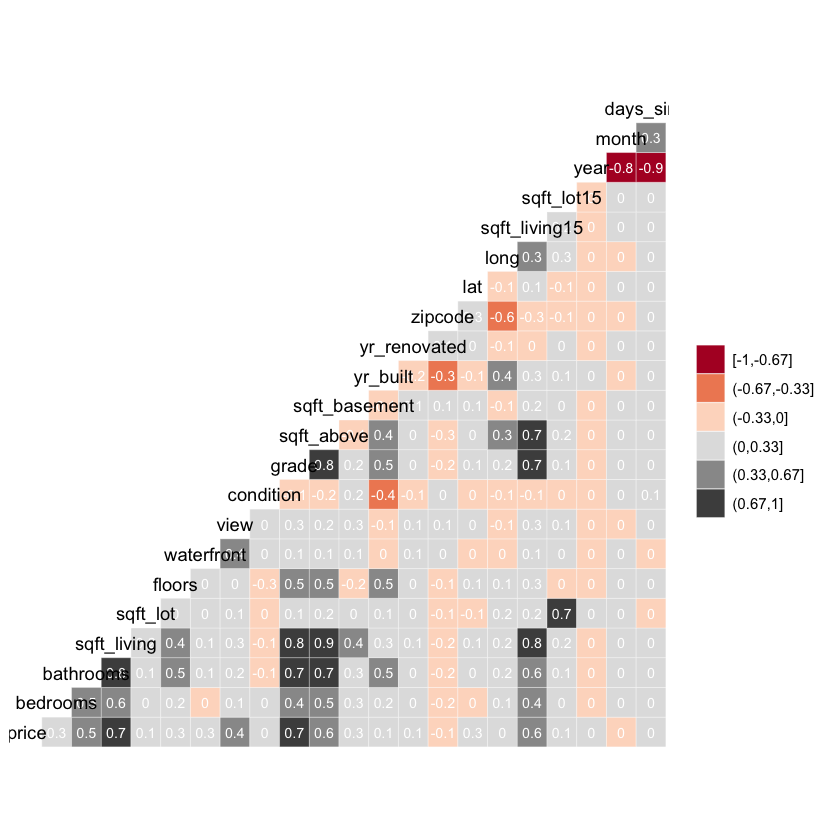

In [27]:
ggcorr(train, nbreaks=6, palette='RdGy', label=TRUE, label_size=3, label_color='white')

#### Subsetting correlations with a threshold of 85%

In [28]:
cor<-as.data.frame(as.table(cor(train)))
subset(cor, abs(Freq) > 0.85 & abs(Freq) < 1)

,Var1,Var2,Freq
77,sqft_above,sqft_living,0.8779126
224,sqft_living,sqft_above,0.8779126
440,days_since,year,-0.8537804
482,year,days_since,-0.8537804


### Linear Dependencies

Caret uses QR decomposition to enumerate sets of linear combinations and therefore, remove them

In [29]:
lc<-findLinearCombos(train)
lc

$linearCombos
$linearCombos[[1]]
[1] 12  4 11


$remove
[1] 12

In [30]:
colnames(train[, 12])

[1] "sqft_basement"

## Baseline Construction

We will perform a baseline against which we will compare our feature engineering efforts to see if they improve the obtained results or not

### Defining Custom Metrics to Evaluate Models

The metric that we will use to tune our model will be  Mean Absolute Percentage Error (MAPE), therefore we need to add it to Caret as a custom metric

In [31]:
customMetrics <- function (data, lev = NULL, model = NULL) {
    c(
        MAPE = mean(abs(data$obs - data$pred)/data$obs),
        MAE = mean(abs(data$obs - data$pred)),
        RMSE = sqrt(mean((data$obs-data$pred)^2)),
        Rsquared = summary(lm(pred ~ obs, data))$r.squared
    )
}

### Defining Cross Validation Strategy

In [32]:
tc<-trainControl(
        method = "cv",
        number=5,
        savePredictions = TRUE,
        summaryFunction = customMetrics)

### Baseline Linear Regression

In [33]:
lm<-train(price~ ., data = train, method = "lm", trControl=tc)
lm$results

intercept,MAPE,MAE,RMSE,Rsquared,MAPESD,MAESD,RMSESD,RsquaredSD
TRUE,0.2552423,125301,198760.9,0.7062242,0.003170039,1814.17,11573.78,0.009663634


## Feature Engineering

A number of different combinations of feature engineering steps and transformations will be performed.

### Drop correlated, CV and linear combination features

Based on the features that were highly correlated, the ones that have a very low coefficient of variation and the ones that must be removed since they are linear combinations, we drop them from the datasets.

In [34]:
train[, c('sqft_above', 'sqft_basement', 'year'):=NULL]
test[, c('sqft_above', 'sqft_basement', 'year'):=NULL]

### Boroughs: Clustering On Location
We do a k-means cluster analysis based on the latitude and longitude of each house, the number of clusters was selected after careful selection to ensure a good distribution of houses in the different sets.

In [35]:
clusters <- kmeans(train[, c("lat", "long")], 12)
str(clusters)

List of 9
 $ cluster     : int [1:17277] 7 8 2 9 9 9 12 6 7 9 ...
 $ centers     : num [1:12, 1:2] 47.6 47.5 47.3 47.5 47.6 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:12] "1" "2" "3" "4" ...
  .. ..$ : chr [1:2] "lat" "long"
 $ totss       : num 677
 $ withinss    : num [1:12] 9.26 6.06 6.46 6.22 3.76 ...
 $ tot.withinss: num 59.9
 $ betweenss   : num 617
 $ size        : int [1:12] 1634 511 1030 1778 1615 1242 1436 2062 1905 1264 ...
 $ iter        : int 5
 $ ifault      : int 0
 - attr(*, "class")= chr "kmeans"


### Predicting Cluster for test set function

In [36]:
predict.kmeans <- function(object, newdata){
    centers <- object$centers
    n_centers <- nrow(centers)
    dist_mat <- as.matrix(dist(rbind(centers, newdata)))
    dist_mat <- dist_mat[-seq(n_centers), seq(n_centers)]
    max.col(-dist_mat)
}

In [37]:
train$borough <- as.factor(clusters$cluster)
test$borough <- as.factor(predict.kmeans(clusters, test[, c("lat", "long")]))

### Distance to centroid of map

Since we do not wish to have latitude and longituded as features, we instead calculate the distance of the house to the centroid of the map.

In [38]:
train$distance<-distm(centroid, train[,c('long','lat')], fun = distHaversine)
test$distance<-distm(centroid, test[,c('long','lat')], fun = distHaversine)

Warning message in `[<-.data.table`(x, j = name, value = value):
“17277 column matrix RHS of := will be treated as one vector”Warning message in `[<-.data.table`(x, j = name, value = value):
“4320 column matrix RHS of := will be treated as one vector”

### Setting up Preprocessing: Centering, Scaling and performing a Yeo Johnson transformation

To reduce the weight/importance of certain features due to their scale, we center them and scale them. We also reduce skewness by performing a Yeo Johnson transformation. This combination will be performed on each model training.

In [48]:
pp<-c("center", "scale", "YeoJohnson")
preProcess(train[,-"price"], method =pp)

Created from 17277 samples and 20 variables

Pre-processing:
  - centered (19)
  - ignored (1)
  - scaled (19)
  - Yeo-Johnson transformation (13)

Lambda estimates for Yeo-Johnson transformation:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-2.6843 -0.5758 -0.1945 -0.1423  0.3409  2.5197 


## One Hot Encoding

Since we have multiple features that could be considered factors, we will try two approaches:

### Boroughs
We one hot encode the boroughs so that each possible value has a column assigned to it.

In [51]:
final<-train
test_copy<-test

dummy<-dummyVars(formula= ~., data = final[, -"price"], fullRank=T, sep = "_")
final<-data.table(predict(dummy, newdata = final[, -"price"]))
final$price<-train$price
test<-data.table(predict(dummy, newdata = test))
test$id<-test_copy$id
head(final)

bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,yr_built,⋯,borough_5,borough_6,borough_7,borough_8,borough_9,borough_10,borough_11,borough_12,distance,price
3,1.50,1250,7500,1,0,0,3,7,1967,⋯,0,0,1,0,0,0,0,0,20991.30,225000
3,2.50,2220,2550,3,0,2,3,10,1990,⋯,0,0,0,1,0,0,0,0,18466.88,641250
4,3.50,3980,209523,2,0,2,3,9,2006,⋯,0,0,0,0,0,0,0,0,27507.96,810000
4,1.50,1890,7540,1,0,0,4,7,1967,⋯,0,0,0,0,1,0,0,0,22196.58,330000
4,1.75,1814,5000,1,0,0,4,7,1951,⋯,0,0,0,0,1,0,0,0,14105.00,530000
4,3.50,3120,5086,2,0,0,3,9,2008,⋯,0,0,0,0,1,0,0,0,13328.88,953007


### Grade, View, Condition and Boroughs
We one hot encode the boroughs but also the grade, view and condition of each apartment.

In [52]:
one_hot<-train
one_hot$grade <- as.factor(one_hot$grade)
one_hot$view <- as.factor(one_hot$view)
one_hot$condition <- as.factor(one_hot$condition)


dummy<-dummyVars(formula= ~., data = one_hot[, -"price"], fullRank=T, sep = "_")
one_hot<-data.table(predict(dummy, newdata = one_hot[, -"price"]))
one_hot$price<-train$price
head(one_hot)

bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view_1,view_2,view_3,view_4,⋯,borough_5,borough_6,borough_7,borough_8,borough_9,borough_10,borough_11,borough_12,distance,price
3,1.50,1250,7500,1,0,0,0,0,0,⋯,0,0,1,0,0,0,0,0,20991.30,225000
3,2.50,2220,2550,3,0,0,1,0,0,⋯,0,0,0,1,0,0,0,0,18466.88,641250
4,3.50,3980,209523,2,0,0,1,0,0,⋯,0,0,0,0,0,0,0,0,27507.96,810000
4,1.50,1890,7540,1,0,0,0,0,0,⋯,0,0,0,0,1,0,0,0,22196.58,330000
4,1.75,1814,5000,1,0,0,0,0,0,⋯,0,0,0,0,1,0,0,0,14105.00,530000
4,3.50,3120,5086,2,0,0,0,0,0,⋯,0,0,0,0,1,0,0,0,13328.88,953007


### Dropping final unneeded features

In [53]:
final[, c('zipcode', 'lat', 'long'):=NULL]
one_hot[, c('zipcode', 'lat', 'long'):=NULL]
test[, c('zipcode', 'lat', 'long'):=NULL]

## Modeling

After the previous feature engineering steps, different models will be cross validated to accurately review the performance of it.

### Linear Regression with One Hot Encoded Boroughs, Grade, View and Condition
After our baseline, now we will try a linear regression again, this time with one hot encoded features.

In [54]:
ini<-now()
lm <- train(price~ ., data = one_hot, method = "lm", trControl=tc, preProcess=pp)
print(now()-ini)
lm$results

Time difference of 14.26363 secs


intercept,MAPE,MAE,RMSE,Rsquared,MAPESD,MAESD,RMSESD,RsquaredSD
TRUE,0.2173376,108724.6,178287.1,0.7647105,0.006321417,2586.917,12037.04,0.01982411


### Random Forest with One Hot Encoded Boroughs
Now we try a random forest with one hot encoded boroughs only.

In [62]:
ini<-now()
rf <- train(price~ ., data = final, method = "ranger", trControl=tc, importance = "impurity", preProcess=pp)
print(now()-ini)
rf$results

Growing trees.. Progress: 28%. Estimated remaining time: 1 minute, 20 seconds.
Growing trees.. Progress: 54%. Estimated remaining time: 52 seconds.
Growing trees.. Progress: 82%. Estimated remaining time: 20 seconds.
Time difference of 32.41267 mins


mtry,min.node.size,splitrule,MAPE,MAE,RMSE,Rsquared,MAPESD,MAESD,RMSESD,RsquaredSD
2,5,variance,0.1924496,93300.07,167620.2,0.8315533,0.002870268,3806.358,22432.34,0.01877165
2,5,extratrees,0.2373424,111943.24,192770.7,0.8153134,0.002998931,4454.875,23970.81,0.01957258
14,5,variance,0.1451836,75946.48,138707.2,0.8605429,0.003888603,3843.798,18003.46,0.01401730
14,5,extratrees,0.1430997,74698.65,136638.6,0.8652342,0.002725741,3608.049,21743.52,0.02060706
27,5,variance,0.1465179,77175.52,141082.7,0.8544062,0.004714635,3870.935,17422.93,0.01387185
27,5,extratrees,0.1418614,74172.61,135734.5,0.8657332,0.002763435,3793.518,22213.61,0.02241531


### Random Forest with One Hot Encoded Boroughs, Grade, View and Condition
Now we try a random forest with one hot encoded features to see which one performs better.

In [66]:
ini<-now()
dummy_rf <- train(price~ ., data = one_hot, method = "ranger", trControl=tc, importance = "impurity", preProcess=pp)
print(now()-ini)
dummy_rf$results

Growing trees.. Progress: 16%. Estimated remaining time: 2 minutes, 40 seconds.
Growing trees.. Progress: 32%. Estimated remaining time: 2 minutes, 14 seconds.
Growing trees.. Progress: 45%. Estimated remaining time: 1 minute, 55 seconds.
Growing trees.. Progress: 61%. Estimated remaining time: 1 minute, 20 seconds.
Growing trees.. Progress: 77%. Estimated remaining time: 45 seconds.
Growing trees.. Progress: 94%. Estimated remaining time: 11 seconds.
Time difference of 47.91649 mins


mtry,min.node.size,splitrule,MAPE,MAE,RMSE,Rsquared,MAPESD,MAESD,RMSESD,RsquaredSD
2,5,variance,0.2337936,109154.98,188982.5,0.8014640,0.003286398,3382.937,14023.017,0.015022043
2,5,extratrees,0.2658284,122310.30,205583.1,0.7864612,0.005348426,4456.577,14430.423,0.015449617
22,5,variance,0.1463698,76451.84,142388.8,0.8524926,0.001288004,1301.741,7153.193,0.004023785
22,5,extratrees,0.1443475,75620.33,140168.8,0.8565640,0.001682432,1818.239,12119.644,0.015772216
42,5,variance,0.1475511,77518.21,144972.2,0.8453426,0.001598156,1122.162,5435.318,0.012147056
42,5,extratrees,0.1420996,74480.38,138795.2,0.8588114,0.001813644,1787.413,11320.390,0.014411563


### XGBoost with One Hot Encoded Boroughs
Now we try an xgb with one hot encoded boroughs only.

In [70]:
ini<-now()
xgb <- train(price~ ., data = final, method = "xgbTree", trControl=tc, importance = TRUE, preProcess=pp)
print(now()-ini)
tail(xgb$results)

,eta,max_depth,gamma,colsample_bytree,min_child_weight,subsample,nrounds,MAPE,MAE,RMSE,Rsquared,MAPESD,MAESD,RMSESD,RsquaredSD
93,0.4,3,0,0.6,1,0.50,150,0.2496854,122033.27,188218.5,0.7359577,0.005145652,2763.703,8334.302,0.032802749
96,0.4,3,0,0.6,1,0.75,150,0.2456763,119747.36,186393.9,0.7416527,0.004374046,1332.973,5877.859,0.026602661
99,0.4,3,0,0.6,1,1.00,150,0.2442133,119109.01,187387.2,0.7389142,0.004293860,2247.635,8267.191,0.027328430
102,0.4,3,0,0.8,1,0.50,150,0.1970375,99776.57,166716.6,0.7934495,0.002457027,1275.850,7108.584,0.011721109
105,0.4,3,0,0.8,1,0.75,150,0.1924826,97016.99,159828.6,0.8104280,0.002509934,1742.210,7782.491,0.009657981
108,0.4,3,0,0.8,1,1.00,150,0.1885728,95605.61,160609.0,0.8083020,0.002465247,1893.538,8896.392,0.018769905


### XGBoost with One Hot Encoded Boroughs, Grade, View and Condition
Now we try an xgb with one hot encoded features to see which one performs better.

In [69]:
ini<-now()
dummy_xgb <- train(price~ ., data = one_hot, method = "xgbTree", trControl=tc, importance = TRUE, preProcess=pp)
print(now()-ini)
tail(dummy_xgb$results)

,eta,max_depth,gamma,colsample_bytree,min_child_weight,subsample,nrounds,MAPE,MAE,RMSE,Rsquared,MAPESD,MAESD,RMSESD,RsquaredSD
93,0.4,3,0,0.6,1,0.50,150,0.2627256,128597.2,202548.0,0.6979701,0.005128088,3626.156,11302.430,0.023701813
96,0.4,3,0,0.6,1,0.75,150,0.2585729,125737.7,193451.1,0.7225634,0.004937725,2932.804,6540.203,0.015662845
99,0.4,3,0,0.6,1,1.00,150,0.2563453,124714.5,191531.0,0.7275813,0.004597393,3141.242,7916.992,0.017955382
102,0.4,3,0,0.8,1,0.50,150,0.2464715,119758.0,186564.8,0.7412090,0.002641711,3377.771,8626.002,0.009510627
105,0.4,3,0,0.8,1,0.75,150,0.2427803,118546.2,188504.5,0.7372550,0.003993509,2010.851,10202.363,0.011963479
108,0.4,3,0,0.8,1,1.00,150,0.2392894,116004.2,180667.3,0.7575203,0.003753913,2264.867,7738.572,0.008046055


## Scores: Comparing Models
### Importances: LM, RF, ONE HOT RF, ONE HOT XGB

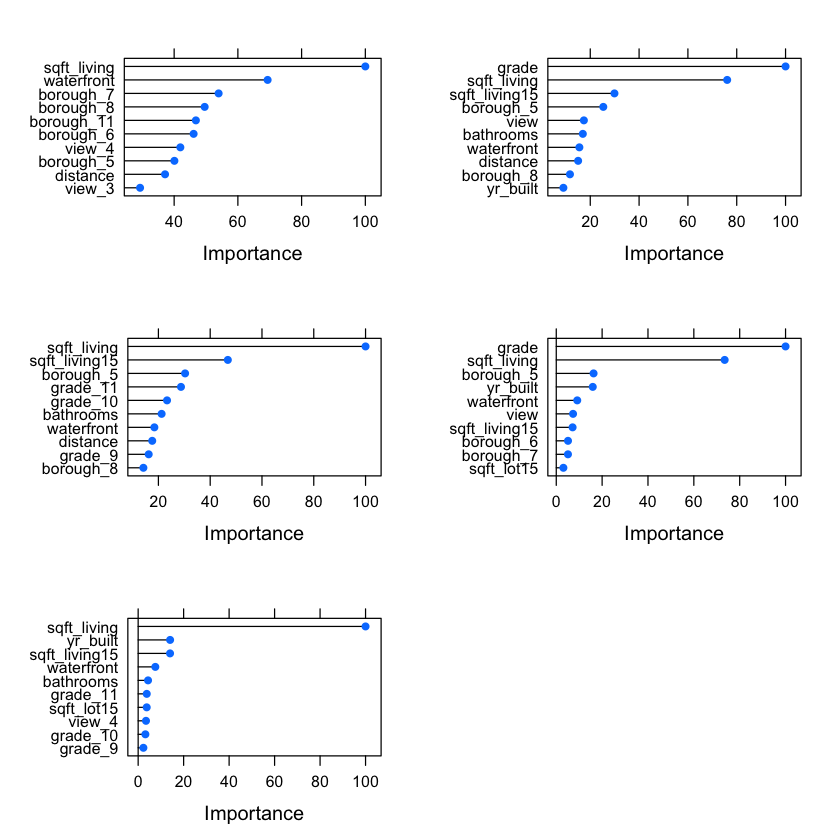

In [71]:
lmplot<-plot(varImp(lm), top = 10)
rfplot<-plot(varImp(rf), top = 10)
dummyrfplot<-plot(varImp(dummy_rf), top = 10)
xgbplot<-plot(varImp(xgb), top = 10)
dummyxgbplot<-plot(varImp(dummy_xgb), top = 10)
grid.arrange(lmplot, rfplot, dummyrfplot, xgbplot, dummyxgbplot, ncol=2)

### Metric Results

In [72]:
results <- resamples(list(
    LM = lm,
    RF = rf,
    DRF = dummy_rf,
    XGB = xgb,
    DXGB = dummy_xgb),
)

summary(results)


Call:
summary.resamples(object = results)

Models: LM, RF, DRF, XGB, DXGB 
Number of resamples: 5 

MAE 
          Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
LM   104620.90 108053.15 109211.19 108724.58 110718.76 111018.92    0
RF    71482.59  71796.86  73006.05  74172.61  73831.86  80745.72    0
DRF   71771.29  73808.92  74721.89  74480.38  76003.66  76096.13    0
XGB   91773.46  93662.25  94207.77  94789.59  97150.49  97153.98    0
DXGB 112912.57 114336.00 114831.28 115577.73 116941.13 118867.66    0

MAPE 
          Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
LM   0.2107190 0.2128584 0.2153554 0.2173376 0.2220751 0.2256802    0
RF   0.1391531 0.1396464 0.1411504 0.1418614 0.1436975 0.1456599    0
DRF  0.1403440 0.1406339 0.1422130 0.1420996 0.1424114 0.1448955    0
XGB  0.1832409 0.1878488 0.1887606 0.1884473 0.1894864 0.1928997    0
DXGB 0.2350725 0.2386068 0.2387986 0.2391551 0.2394983 0.2437994    0

RMSE 
         Min.  1st Qu.   Median     Mean

### Plots of Results

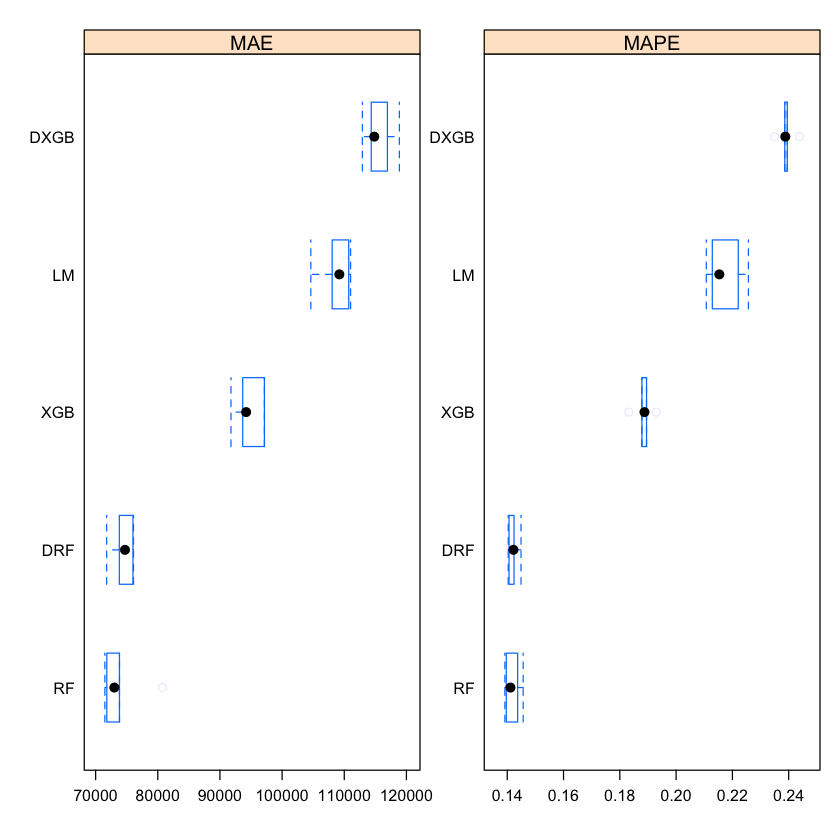

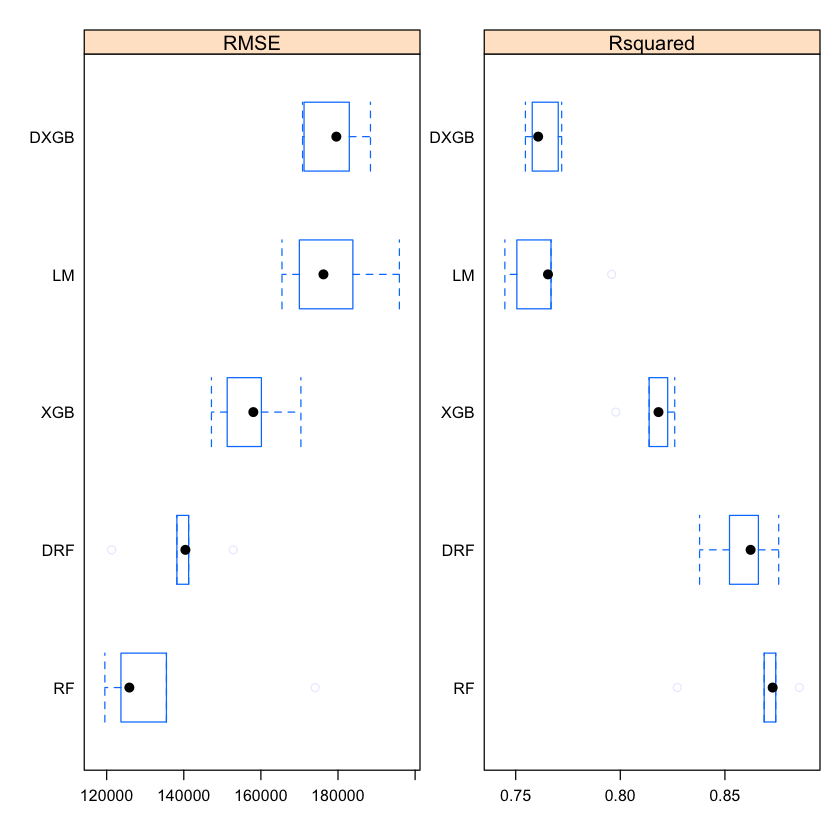

In [73]:
bwplot(results, layout = c(2, 1), scales = list(relation="free"))

Finally, we choose the random forest with one hot encoded boroughs only since overall, it is the best performing one.

## Hyperparameter Tuning Through Repeated Cross Validated Randomized Grid Search

Finally we perform a cross validated, randomized grid search on the chosen random forest in order to define the final model, the chosen one will be the one with the smallest MAPE.

In [76]:
grid<-expand.grid(
    mtry=c(22,27),
    splitrule=c('extratrees'),
    min.node.size=c(3,5,8)
)

tc<-trainControl(
    method = "repeatedcv",
    number=5,
    repeats = 2,
    savePredictions = TRUE,
    summaryFunction = customMetrics,
    search = "random"
)

ini<-now()

grid_rf <- train(
    price ~ .,
    data = final,
    method = "ranger",
    num.trees=500,
    maximize=FALSE,
    tuneGrid = grid,
    trControl = tc,
    metric = "MAPE",
    tuneLength = 5,
    preProcess=pp
)

print(now()-ini)

grid_rf

Growing trees.. Progress: 24%. Estimated remaining time: 1 minute, 37 seconds.
Growing trees.. Progress: 48%. Estimated remaining time: 1 minute, 7 seconds.
Growing trees.. Progress: 71%. Estimated remaining time: 37 seconds.
Growing trees.. Progress: 96%. Estimated remaining time: 5 seconds.
Time difference of 1.785979 hours


Random Forest 

17277 samples
   27 predictor

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 2 times) 
Summary of sample sizes: 13821, 13821, 13822, 13822, 13822, 13822, ... 
Resampling results across tuning parameters:

  mtry  min.node.size  MAPE       MAE       RMSE      Rsquared 
  22    3              0.1416262  74061.87  136824.3  0.8628895
  22    5              0.1419723  74238.53  136802.6  0.8630870
  22    8              0.1428093  74623.88  137251.8  0.8621614
  27    3              0.1413146  73957.37  136622.9  0.8630170
  27    5              0.1417140  74139.04  136801.5  0.8626759
  27    8              0.1423787  74517.58  137510.6  0.8612819

Tuning parameter 'splitrule' was held constant at a value of extratrees
MAPE was used to select the optimal model using the smallest value.
The final values used for the model were mtry = 27, splitrule = extratrees
 and min.node.size = 3.

In [77]:
grid_rf$bestTune

,mtry,splitrule,min.node.size
4,27,extratrees,3


In [78]:
grid_rf$finalModel

Ranger result

Call:
 ranger::ranger(dependent.variable.name = ".outcome", data = x,      mtry = param$mtry, min.node.size = param$min.node.size, splitrule = as.character(param$splitrule),      write.forest = TRUE, probability = classProbs, ...) 

Type:                             Regression 
Number of trees:                  500 
Sample size:                      17277 
Number of independent variables:  27 
Mtry:                             27 
Target node size:                 3 
Variable importance mode:         none 
Splitrule:                        extratrees 
OOB prediction error (MSE):       18340736271 
R squared (OOB):                  0.8634678 

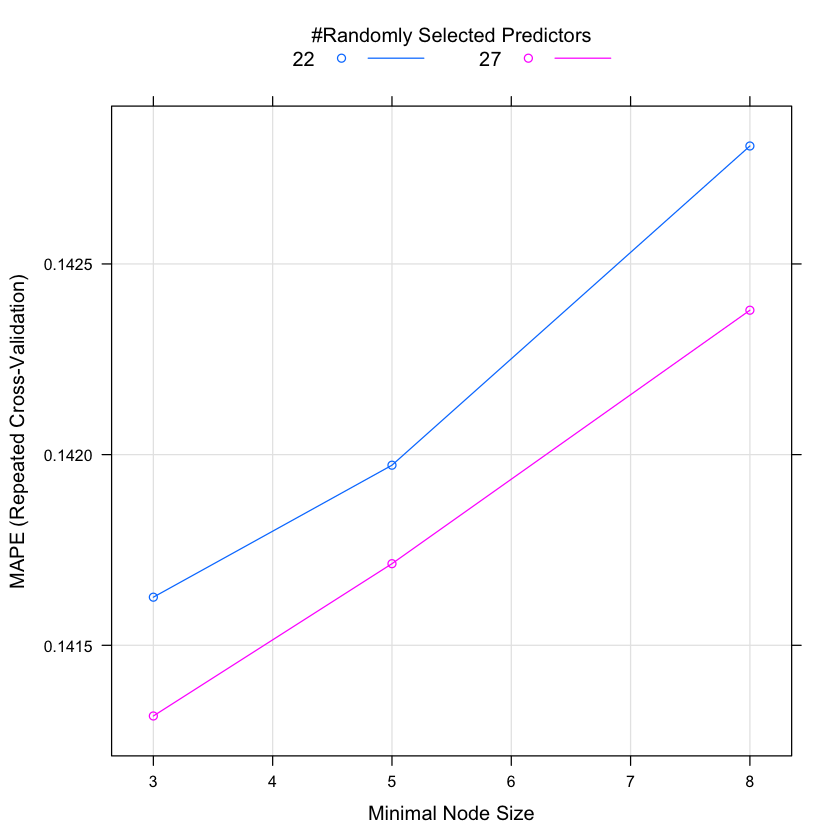

In [79]:
plot(grid_rf)

## Predicting
We predict on the test set, add the predictions to it and create our predictions file.

In [80]:
predicted <- predict(grid_rf, newdata = test[,-"id"])
df_pred<-cbind(test, predicted)
head(df_pred[,c("id", "predicted")])

id,predicted
3.168987e-314,543811.3
2.991395e-314,378424.6
7.905246e-317,194755.6
1.247046e-314,1455276.5
4.230561e-314,557292.3
3.749563e-314,572542.9


### Export Predictions

In [81]:
fwrite(df_pred[,c("id", "predicted")],"predictions.csv")

### Export Model

In [134]:
saveRDS(grid_rf$finalModel, "final_model.rds")

## Conclusions
After careful exploratory analysis, we were able to perform multiple feature engineering steps that increased the performance of our models, from them, we were able to choose one model in order to perform a randomized repeated and cross validated grid search in order to tune it to our data, finally, we were able to predict our testing dataset based on this entire process.

It must be noted that performing feature engineering is one of the most important steps in the process, working with metrics like latitude and longitude can sometimes complicate things, that is why we must find ways to extract that information into ways that the different models can use it and take advantage of it.

Overall, our training results are very satisfactory, which gives us the confidence that we have created a good model that can accurately estimate the prices of different houses. The uses of a model like this are countless and it will surely help the relevant stakeholders to make better decisions.

In [45]:
stopCluster(cluster)